In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer,RobustScaler,StandardScaler
from joblib import dump
import tensorflow as tf


In [2]:
ratings_df = pd.read_csv('data\\user-filtered.csv')
anime_metadata_df = pd.read_csv('data\\anime-filtered.csv')
user_df = pd.read_csv('data\\users-details-2023.csv')

In [3]:
user_df

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0
1,3,Aokaado,Male,NaN,"Oslo, Norway",2004-11-11T00:00:00+00:00,68.6,7.34,23.0,137.0,99.0,44.0,40.0,343.0,15.0,4072.0
2,4,Crystal,Female,NaN,"Melbourne, Australia",2004-11-13T00:00:00+00:00,212.8,6.68,16.0,636.0,303.0,0.0,45.0,1000.0,10.0,12781.0
3,9,Arcane,NaN,NaN,NaN,2004-12-05T00:00:00+00:00,30.0,7.71,5.0,54.0,4.0,3.0,0.0,66.0,0.0,1817.0
4,18,Mad,NaN,NaN,NaN,2005-01-03T00:00:00+00:00,52.0,6.27,1.0,114.0,10.0,5.0,23.0,153.0,42.0,3038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731285,1291083,Dolopa,NaN,NaN,NaN,2012-05-06T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731286,1291085,alenrobnik,NaN,NaN,NaN,2012-05-06T00:00:00+00:00,21.4,8.22,16.0,58.0,9.0,1.0,42.0,126.0,0.0,1239.0
731287,1291087,Oblongata,NaN,1993-01-30T00:00:00+00:00,NaN,2012-05-06T00:00:00+00:00,51.3,7.53,38.0,175.0,0.0,9.0,211.0,433.0,2.0,3010.0
731288,1291091,Etnota,NaN,NaN,NaN,2012-05-06T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
user_df.drop(["Joined","Days Watched","Watching","Completed","On Hold","Dropped",	"Plan to Watch",	"Total Entries",	"Rewatched",	"Episodes Watched" , "Username", "Location"],axis=1,inplace=True)

In [5]:
user_df['age'] = pd.to_datetime(user_df['Birthday'],errors='coerce').apply(lambda x: 2024 - x.year)  # Convert birthday to age
user_df.drop(['Birthday'],axis=1,inplace=True)
user_df

,Mal ID,Gender,Mean Score,age
0,1,Male,7.37,39.0
1,3,Male,7.34,NaN
2,4,Female,6.68,NaN
3,9,NaN,7.71,NaN
4,18,NaN,6.27,NaN
...,...,...,...,...
731285,1291083,NaN,0.00,NaN
731286,1291085,NaN,8.22,NaN
731287,1291087,NaN,7.53,31.0
731288,1291091,NaN,0.00,NaN


In [6]:
# Calculate the mean of the column
mean_value = user_df['age'].mean()

# Fill missing values with the mean
user_df['age'].fillna(mean_value, inplace=True)

In [7]:
user_df=user_df[user_df['Mean Score']!=0.00]
user_df=user_df[user_df['Mean Score'].notna()]
user_df

,Mal ID,Gender,Mean Score,age
0,1,Male,7.37,39.000000
1,3,Male,7.34,33.691946
2,4,Female,6.68,33.691946
3,9,NaN,7.71,33.691946
4,18,NaN,6.27,33.691946
...,...,...,...,...
731280,1291057,Male,7.00,27.000000
731284,1291079,Male,8.48,33.691946
731286,1291085,NaN,8.22,33.691946
731287,1291087,NaN,7.53,31.000000


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355086 entries, 0 to 731289
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Mal ID      355086 non-null  int64  
 1   Gender      190695 non-null  object 
 2   Mean Score  355086 non-null  float64
 3   age         355086 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 13.5+ MB


In [9]:
def convert_cat_to_one_hot(df,col,unknown_name):
    df[col] = df[col].fillna(unknown_name)
    one_hot_encoded = pd.get_dummies(df[col],dtype='int64')
    
    # Concatenate the one-hot encoded gender columns with the original DataFrame
    df = pd.concat([df, one_hot_encoded], axis=1)
    df.drop([col],axis=1,inplace=True)
    return df

In [10]:
def sep_and_conv_cat_to_one_hot(df,col,unknown_name):
    df[col] = df[col].fillna(unknown_name)
    one_hot_encoded = df[col].str.get_dummies(', ')
    
    # Concatenate the one-hot encoded gender columns with the original DataFrame
    df = pd.concat([df, one_hot_encoded], axis=1)
    df.drop([col],axis=1,inplace=True)
    return df

In [11]:
user_df=convert_cat_to_one_hot(user_df,'Gender','Unknown_Gender')

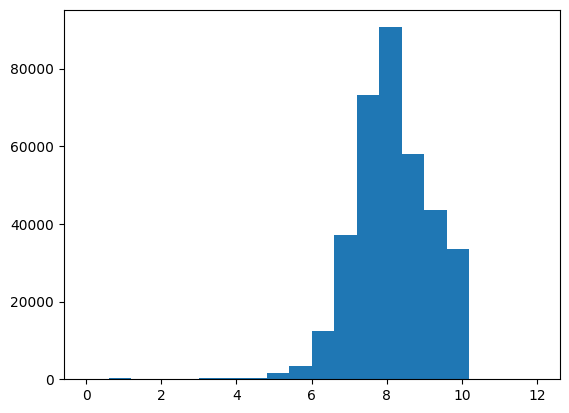

In [12]:
plt.hist(user_df['Mean Score'],range=(0,12),bins=20)
plt.show()


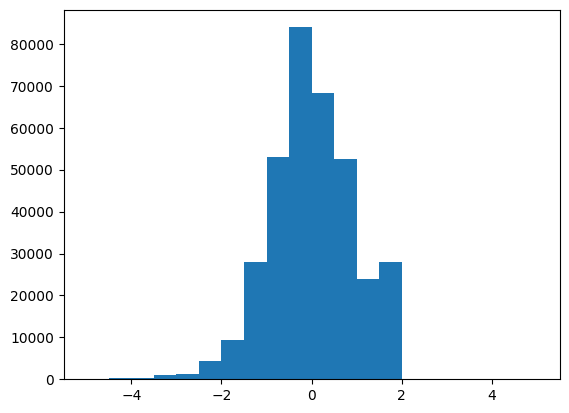

In [13]:
column_to_transform = user_df['Mean Score']
transformer = PowerTransformer(method='yeo-johnson',standardize=True)

# Fit the transformer to the column and transform it
transformed_column = transformer.fit_transform(column_to_transform.values.reshape(-1, 1))

# Convert the transformed array back to DataFrame (optional)

plt.hist(transformed_column,range=(-5,5),bins=20)
plt.show()
# Assign the transformed values back to the DataFrame
user_df['Mean Score'] = transformed_column

In [14]:

dump(transformer, 'intermediate_data/mean_score_scaler.pkl') #saving scaler for use in production

['mean_score_scaler.pkl']

In [15]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355086 entries, 0 to 731289
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Mal ID          355086 non-null  int64  
 1   Mean Score      355086 non-null  float64
 2   age             355086 non-null  float64
 3   Female          355086 non-null  int64  
 4   Male            355086 non-null  int64  
 5   Non-Binary      355086 non-null  int64  
 6   Unknown_Gender  355086 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 21.7 MB


In [16]:
user_df

,Mal ID,Mean Score,age,Female,Male,Non-Binary,Unknown_Gender
0,1,-0.696093,39.000000,0,1,0,0
1,3,-0.724716,33.691946,0,1,0,0
2,4,-1.363115,33.691946,1,0,0,0
3,9,-0.373963,33.691946,0,0,0,1
4,18,-1.768592,33.691946,0,0,0,1
...,...,...,...,...,...,...,...
731280,1291057,-1.051472,27.000000,0,1,0,0
731284,1291079,0.341001,33.691946,0,1,0,0
731286,1291085,0.101751,33.691946,0,0,0,1
731287,1291087,-0.543988,31.000000,0,0,0,1


In [17]:
user_ratings_df = pd.merge(ratings_df, user_df, left_on='user_id' , right_on= 'Mal ID')
user_ratings_df.drop(['Mal ID'],axis=1,inplace=True)
user_ratings_df

,user_id,anime_id,rating,Mean Score,age,Female,Male,Non-Binary,Unknown_Gender
0,1,37403,8,-0.696093,39.000000,0,1,0,0
1,1,9989,0,-0.696093,39.000000,0,1,0,0
2,1,24833,0,-0.696093,39.000000,0,1,0,0
3,1,7674,7,-0.696093,39.000000,0,1,0,0
4,1,34572,0,-0.696093,39.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...
60046596,353404,507,7,-1.051472,33.691946,0,0,0,1
60046597,353404,392,9,-1.051472,33.691946,0,0,0,1
60046598,353404,882,6,-1.051472,33.691946,0,0,0,1
60046599,353404,883,8,-1.051472,33.691946,0,0,0,1


In [18]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60046601 entries, 0 to 60046600
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   anime_id        int64  
 2   rating          int64  
 3   Mean Score      float64
 4   age             float64
 5   Female          int64  
 6   Male            int64  
 7   Non-Binary      int64  
 8   Unknown_Gender  int64  
dtypes: float64(2), int64(7)
memory usage: 4.0 GB


In [19]:
anime_metadata_df

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,48481,Daomu Biji Zhi Qinling Shen Shu,6.51,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,No synopsis information has been added to this...,ONA,Unknown,"Apr 4, 2021 to ?",...,Unknown,Unknown,NaN,13116,354,6,0,0,0,0
14948,48483,Mieruko-chan,6.51,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,ko is a typical high school student whose life...,TV,Unknown,2021 to ?,...,Unknown,Unknown,NaN,17562,7010,70,14,0,14,0
14949,48488,Higurashi no Naku Koro ni Sotsu,6.51,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,Sequel to Higurashi no Naku Koro ni Gou .,TV,Unknown,"Jul, 2021 to ?",...,Unknown,R - 17+ (violence & profanity),NaN,17558,11309,48,3,0,0,0
14950,48491,Yama no Susume: Next Summit,6.51,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,New Yama no Susume anime.,TV,Unknown,Unknown,...,Unknown,PG-13 - Teens 13 or older,NaN,17565,1386,2,13,2,2,1


In [20]:
anime_metadata_df.drop(["Name",'English name','Japanese name','sypnopsis','Premiered','Episodes','Duration','Rating','Popularity',	'Members',	'Favorites',	'Watching',	'Completed',	'On-Hold',	'Dropped','Licensors','Producers' , 'Aired' , 'Ranked'],axis=1,inplace=True)

In [21]:
#anime_metadata_df['Genres'] = anime_metadata_df['Genres'].fillna('')
#anime_metadata_df['sypnopsis'] = anime_metadata_df['sypnopsis'].fillna('')
#anime_metadata_df['Genres'] = anime_metadata_df['Genres'].apply(lambda x: x.split(','))
#anime_metadata_df['Genres'] = anime_metadata_df['Genres'].apply(lambda x: ' '.join(x))
#anime_metadata_df['sypnopsis'] = anime_metadata_df['sypnopsis'].apply(lambda x: len(x.split()))
#anime_metadata_df

In [22]:
unique_strings = anime_metadata_df['Type'].unique()

# Print the unique strings
print(unique_strings)

['TV' 'Movie' 'OVA' 'Special' 'ONA' 'Music' 'Unknown']


In [23]:
anime_metadata_df['Type'] = anime_metadata_df['Type'].replace('Unknown', 'Unknown_Type')
anime_metadata_df['Source'] = anime_metadata_df['Source'].replace('Unknown', 'Unknown_Source')
anime_metadata_df['Genres'] = anime_metadata_df['Genres'].replace('Unknown', 'Unknown_Genre')
anime_metadata_df['Source'] = anime_metadata_df['Source'].replace('Music', 'Music_Source')
anime_metadata_df['Source'] = anime_metadata_df['Source'].replace('Game', 'Game_Source')
anime_metadata_df['Type'] = anime_metadata_df['Type'].replace('Music', 'Music_Type')

In [24]:
# # Define the strings you want to remove
# string_to_remove = 'Music'

# # Remove rows where 'apple' or 'orange' appears in 'col2'
# anime_metadata_df  = anime_metadata_df[anime_metadata_df['Type'] != string_to_remove]

In [25]:
anime_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  14952 non-null  int64  
 1   Score     14952 non-null  float64
 2   Genres    14952 non-null  object 
 3   Type      14952 non-null  object 
 4   Studios   14952 non-null  object 
 5   Source    14952 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 701.0+ KB


In [26]:
anime_metadata_df

,anime_id,Score,Genres,Type,Studios,Source
0,1,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Sunrise,Original
1,5,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,Bones,Original
2,6,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Madhouse,Manga
3,7,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,Sunrise,Original
4,8,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,Toei Animation,Manga
...,...,...,...,...,...,...
14947,48481,6.51,"Adventure, Mystery, Supernatural",ONA,Unknown,Novel
14948,48483,6.51,"Comedy, Horror, Supernatural",TV,Passione,Manga
14949,48488,6.51,"Mystery, Dementia, Horror, Psychological, Supe...",TV,Unknown,Visual novel
14950,48491,6.51,"Adventure, Slice of Life, Comedy",TV,8bit,Manga


In [27]:
Type_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist',dtype='int64')  # Create an instance of OneHotEncoder
encoded_Types = Type_encoder.fit_transform(anime_metadata_df[['Type']])  # Fit and transform the column
encoded_df = pd.DataFrame(encoded_Types.toarray(), columns=Type_encoder.categories_[0])  # Create a DataFrame from the encoded columns

anime_metadata_df=pd.concat([anime_metadata_df, encoded_df], axis=1)  # Concatenate the original DataFrame with the encoded DataFrame
anime_metadata_df.drop(['Type'],axis=1,inplace=True)


In [28]:
Source_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist',dtype='int64')  # Create an instance of OneHotEncoder
encoded_Sources = Source_encoder.fit_transform(anime_metadata_df[['Source']])  # Fit and transform the column
encoded_df = pd.DataFrame(encoded_Sources.toarray(), columns=Source_encoder.categories_[0])  # Create a DataFrame from the encoded columns

anime_metadata_df=pd.concat([anime_metadata_df, encoded_df], axis=1)  # Concatenate the original DataFrame with the encoded DataFrame
anime_metadata_df.drop(['Source'],axis=1,inplace=True)

In [29]:
genre_encoder = MultiLabelBinarizer()
encoded_genres=genre_encoder.fit_transform(anime_metadata_df['Genres'].str.split(", "))
encoded_df = pd.DataFrame(encoded_genres, columns=genre_encoder.classes_)  # Create a DataFrame from the encoded columns

anime_metadata_df=pd.concat([anime_metadata_df, encoded_df], axis=1)  # Concatenate the original DataFrame with the encoded DataFrame
anime_metadata_df.drop(['Genres'],axis=1,inplace=True)


#### saving encoders for use in production

In [30]:
dump(Type_encoder,'intermediate_data/Type_encoder.pkl')
dump(Source_encoder,'intermediate_data/Source_encoder.pkl')
dump(genre_encoder,'intermediate_data/genre_encoder.pkl')

['genre_encoder.pkl']

In [31]:
# anime_metadata_df=sep_and_conv_cat_to_one_hot(anime_metadata_df,'Genres','Unknown_Genre')
# anime_metadata_df=convert_cat_to_one_hot(anime_metadata_df,'Type','Unknown_Type')
# anime_metadata_df=convert_cat_to_one_hot(anime_metadata_df,'Source','Unknown_Source')

In [32]:
anime_metadata_df

,anime_id,Score,Studios,Movie,Music_Type,ONA,OVA,Special,TV,Unknown_Type,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown_Genre,Vampire,Yaoi,Yuri
0,1,8.78,Sunrise,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,5,8.39,Bones,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,6,8.24,Madhouse,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,7.27,Sunrise,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,8,6.98,Toei Animation,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,48481,6.51,Unknown,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14948,48483,6.51,Passione,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
14949,48488,6.51,Unknown,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
14950,48491,6.51,8bit,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
anime_metadata_df.columns

Index(['anime_id', 'Score', 'Studios', 'Movie', 'Music_Type', 'ONA', 'OVA',
       'Special', 'TV', 'Unknown_Type', '4-koma manga', 'Book', 'Card game',
       'Digital manga', 'Game_Source', 'Light novel', 'Manga', 'Music_Source',
       'Novel', 'Original', 'Other', 'Picture book', 'Radio', 'Unknown_Source',
       'Visual novel', 'Web manga', 'Action', 'Adventure', 'Cars', 'Comedy',
       'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem',
       'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown_Genre', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

In [34]:

uniqueList = []
duplicateList = []
 
for i in anime_metadata_df.columns:
    if i not in uniqueList:
        uniqueList.append(i)
    elif i not in duplicateList:
        duplicateList.append(i)
 
print(duplicateList)

[]


In [35]:
studio_to_int = {}
int_to_studio = {}
index = 0
for studios in anime_metadata_df['Studios'].str.split(', '):
    for studio in studios:
        if studio not in studio_to_int:
            studio_to_int[studio] = index
            int_to_studio[index] = studio
            index += 1

# Convert studio names to sequences of integers
sequences = []
for studios in anime_metadata_df['Studios'].str.split(', '):
    sequence = [studio_to_int[studio] for studio in studios]
    sequences.append(sequence)

max_length = max(len(lst) for lst in sequences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post')
padded_columns = pd.DataFrame(padded_sequences, columns=[f'studio_col_{i+1}' for i in range(max_length)])
anime_metadata_df=pd.concat([anime_metadata_df,padded_columns],axis=1)
anime_metadata_df.drop('Studios',axis=1,inplace=True)

In [36]:
index

689

In [37]:
anime_metadata_df

,anime_id,Score,Movie,Music_Type,ONA,OVA,Special,TV,Unknown_Type,4-koma manga,...,Vampire,Yaoi,Yuri,studio_col_1,studio_col_2,studio_col_3,studio_col_4,studio_col_5,studio_col_6,studio_col_7
0,1,8.78,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,8.39,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6,8.24,0,0,0,0,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
3,7,7.27,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,6.98,0,0,0,0,0,1,0,0,...,0,0,0,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,48481,6.51,0,0,1,0,0,0,0,0,...,0,0,0,46,0,0,0,0,0,0
14948,48483,6.51,0,0,0,0,0,1,0,0,...,0,0,0,347,0,0,0,0,0,0
14949,48488,6.51,0,0,0,0,0,1,0,0,...,0,0,0,46,0,0,0,0,0,0
14950,48491,6.51,0,0,0,0,0,1,0,0,...,0,0,0,244,0,0,0,0,0,0


#### saving vocabularies for use in production

In [38]:
dump(studio_to_int,'intermediate_data/studio_to_int_vocab_dict.pkl')
dump(int_to_studio,'intermediate_data/int_to_studio_vocab_dict.pkl')

['int_to_studio_vocab_dict.pkl']

In [39]:
anime_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14952 non-null  int64  
 1   Score           14952 non-null  float64
 2   Movie           14952 non-null  int64  
 3   Music_Type      14952 non-null  int64  
 4   ONA             14952 non-null  int64  
 5   OVA             14952 non-null  int64  
 6   Special         14952 non-null  int64  
 7   TV              14952 non-null  int64  
 8   Unknown_Type    14952 non-null  int64  
 9   4-koma manga    14952 non-null  int64  
 10  Book            14952 non-null  int64  
 11  Card game       14952 non-null  int64  
 12  Digital manga   14952 non-null  int64  
 13  Game_Source     14952 non-null  int64  
 14  Light novel     14952 non-null  int64  
 15  Manga           14952 non-null  int64  
 16  Music_Source    14952 non-null  int64  
 17  Novel           14952 non-null 

## saving processed data

In [40]:
user_ratings_df.to_pickle("intermediate_data/user_rating_df_temp.pkl")
anime_metadata_df.to_pickle("intermediate_data/anime_metadata_df_temp.pkl")

## downcasting data to save space

In [2]:
user_ratings_df=pd.read_pickle("intermediate_data/user_rating_df_temp.pkl")
anime_metadata_df=pd.read_pickle("intermediate_data/anime_metadata_df_temp.pkl")

In [3]:
user_ratings_df

,user_id,anime_id,rating,Mean Score,age,Female,Male,Non-Binary,Unknown_Gender
0,1,37403,8,-0.696093,39.000000,0,1,0,0
1,1,9989,0,-0.696093,39.000000,0,1,0,0
2,1,24833,0,-0.696093,39.000000,0,1,0,0
3,1,7674,7,-0.696093,39.000000,0,1,0,0
4,1,34572,0,-0.696093,39.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...
60046596,353404,507,7,-1.051472,33.691946,0,0,0,1
60046597,353404,392,9,-1.051472,33.691946,0,0,0,1
60046598,353404,882,6,-1.051472,33.691946,0,0,0,1
60046599,353404,883,8,-1.051472,33.691946,0,0,0,1


In [4]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60046601 entries, 0 to 60046600
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   anime_id        int64  
 2   rating          int64  
 3   Mean Score      float64
 4   age             float64
 5   Female          int64  
 6   Male            int64  
 7   Non-Binary      int64  
 8   Unknown_Gender  int64  
dtypes: float64(2), int64(7)
memory usage: 4.0 GB


#### function to downcast a dataframe

In [5]:
def downcast_df(df):
    # Downcast int columns to float types
    int_cols = df.select_dtypes(include=['int']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    # Downcast float columns to float types
    float_cols = df.select_dtypes(include=['float']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

In [6]:
downcast_df(user_ratings_df)
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60046601 entries, 0 to 60046600
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int32  
 1   anime_id        int32  
 2   rating          int8   
 3   Mean Score      float32
 4   age             float32
 5   Female          int8   
 6   Male            int8   
 7   Non-Binary      int8   
 8   Unknown_Gender  int8   
dtypes: float32(2), int32(2), int8(5)
memory usage: 1.2 GB


In [7]:
anime_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14952 non-null  int64  
 1   Score           14952 non-null  float64
 2   Movie           14952 non-null  int64  
 3   Music_Type      14952 non-null  int64  
 4   ONA             14952 non-null  int64  
 5   OVA             14952 non-null  int64  
 6   Special         14952 non-null  int64  
 7   TV              14952 non-null  int64  
 8   Unknown_Type    14952 non-null  int64  
 9   4-koma manga    14952 non-null  int64  
 10  Book            14952 non-null  int64  
 11  Card game       14952 non-null  int64  
 12  Digital manga   14952 non-null  int64  
 13  Game_Source     14952 non-null  int64  
 14  Light novel     14952 non-null  int64  
 15  Manga           14952 non-null  int64  
 16  Music_Source    14952 non-null  int64  
 17  Novel           14952 non-null 

In [8]:
downcast_df(anime_metadata_df)

##### since anime_metadata_df has too many columns,  sometimes using the downcast function returns a weird error. Hence I have provided code to downcast it manually

In [9]:
# int_cols = anime_metadata_df.select_dtypes(include=['int64']).columns
# int_cols

In [10]:
# for i in range(len(int_cols)):
#     anime_metadata_df[int_cols[i]] = anime_metadata_df[int_cols[i]].apply(pd.to_numeric,downcast='integer')

In [11]:
# anime_metadata_df[int_cols[0]] = anime_metadata_df[int_cols[0]].apply(pd.to_numeric,downcast='integer')

In [12]:
# for i in range(len(int_cols)):
#     anime_metadata_df[int_cols[i]] = pd.to_numeric(anime_metadata_df[int_cols[i]] , downcast='integer')

In [13]:
# float_cols = anime_metadata_df.select_dtypes(include=['float']).columns
# float_cols

In [14]:
# for i in range(len(float_cols)):
#     anime_metadata_df[float_cols[i]] = pd.to_numeric(anime_metadata_df[float_cols[i]] , downcast='float')

In [15]:
# anime_metadata_df[int_cols[0]] = pd.to_numeric(anime_metadata_df[int_cols[0]] , downcast='integer')

In [16]:
# for col in int_cols:
#     anime_metadata_df[col] = anime_metadata_df[col].apply(pd.to_numeric,downcast='integer')


In [17]:
anime_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14952 non-null  int32  
 1   Score           14952 non-null  float32
 2   Movie           14952 non-null  int8   
 3   Music_Type      14952 non-null  int8   
 4   ONA             14952 non-null  int8   
 5   OVA             14952 non-null  int8   
 6   Special         14952 non-null  int8   
 7   TV              14952 non-null  int8   
 8   Unknown_Type    14952 non-null  int8   
 9   4-koma manga    14952 non-null  int8   
 10  Book            14952 non-null  int8   
 11  Card game       14952 non-null  int8   
 12  Digital manga   14952 non-null  int8   
 13  Game_Source     14952 non-null  int8   
 14  Light novel     14952 non-null  int8   
 15  Manga           14952 non-null  int8   
 16  Music_Source    14952 non-null  int8   
 17  Novel           14952 non-null 

## saving downcasted data

In [18]:
anime_metadata_df.to_pickle("intermediate_data/anime_metadata_df_downcasted.pkl")
user_ratings_df.to_pickle("intermediate_data/user_rating_df_downcasted.pkl")

# merging the user and anime tables to get final table

In [2]:
anime_metadata_df=pd.read_pickle("intermediate_data/anime_metadata_df_downcasted.pkl")
user_ratings_df=pd.read_pickle("intermediate_data/user_rating_df_downcasted.pkl")

In [3]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60046601 entries, 0 to 60046600
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int32  
 1   anime_id        int32  
 2   rating          int8   
 3   Mean Score      float32
 4   age             float32
 5   Female          int8   
 6   Male            int8   
 7   Non-Binary      int8   
 8   Unknown_Gender  int8   
dtypes: float32(2), int32(2), int8(5)
memory usage: 1.2 GB


In [4]:
anime_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14952 non-null  int32  
 1   Score           14952 non-null  float32
 2   Movie           14952 non-null  int8   
 3   Music_Type      14952 non-null  int8   
 4   ONA             14952 non-null  int8   
 5   OVA             14952 non-null  int8   
 6   Special         14952 non-null  int8   
 7   TV              14952 non-null  int8   
 8   Unknown_Type    14952 non-null  int8   
 9   4-koma manga    14952 non-null  int8   
 10  Book            14952 non-null  int8   
 11  Card game       14952 non-null  int8   
 12  Digital manga   14952 non-null  int8   
 13  Game_Source     14952 non-null  int8   
 14  Light novel     14952 non-null  int8   
 15  Manga           14952 non-null  int8   
 16  Music_Source    14952 non-null  int8   
 17  Novel           14952 non-null 

In [5]:

merged_df = pd.merge(user_ratings_df, anime_metadata_df, on='anime_id')

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59968480 entries, 0 to 59968479
Data columns (total 84 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int32  
 1   anime_id        int32  
 2   rating          int8   
 3   Mean Score      float32
 4   age             float32
 5   Female          int8   
 6   Male            int8   
 7   Non-Binary      int8   
 8   Unknown_Gender  int8   
 9   Score           float32
 10  Movie           int8   
 11  Music_Type      int8   
 12  ONA             int8   
 13  OVA             int8   
 14  Special         int8   
 15  TV              int8   
 16  Unknown_Type    int8   
 17  4-koma manga    int8   
 18  Book            int8   
 19  Card game       int8   
 20  Digital manga   int8   
 21  Game_Source     int8   
 22  Light novel     int8   
 23  Manga           int8   
 24  Music_Source    int8   
 25  Novel           int8   
 26  Original        int8   
 27  Other           int8   
 28  Picture bo

In [7]:
merged_df.to_pickle("intermediate_data/merged_final.pkl")

In [2]:
merged_df=pd.read_pickle("intermediate_data/merged_final.pkl")

In [3]:
merged_npy=merged_df.to_numpy(dtype='float32')

In [6]:
merged_npy.shape

(59968480, 84)

In [8]:
np.save('intermediate_data/merged.npy',merged_npy)

In [8]:
merged_df

,user_id,anime_id,rating,Mean Score,age,Female,Male,Non-Binary,Unknown_Gender,Score,...,Vampire,Yaoi,Yuri,studio_col_1,studio_col_2,studio_col_3,studio_col_4,studio_col_5,studio_col_6,studio_col_7
0,1,37403,8,-0.696093,39.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
1,44,37403,0,-0.477731,33.691944,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
2,82,37403,0,-0.887547,35.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
3,111,37403,8,-0.887547,33.691944,0,0,0,1,7.35,...,0,0,0,110,0,0,0,0,0,0
4,222,37403,9,0.304332,37.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59968475,100869,48492,0,-0.383379,34.000000,1,0,0,0,6.51,...,0,0,0,0,0,0,0,0,0,0
59968476,239658,48492,0,-0.102392,33.000000,1,0,0,0,6.51,...,0,0,0,0,0,0,0,0,0,0
59968477,310503,48492,0,1.699864,33.691944,0,0,0,1,6.51,...,0,0,0,0,0,0,0,0,0,0
59968478,123205,48481,0,0.267613,33.000000,1,0,0,0,6.51,...,0,0,0,46,0,0,0,0,0,0


In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59968480 entries, 0 to 59968479
Data columns (total 84 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int32  
 1   anime_id       int32  
 2   rating         int8   
 3   Mean Score     float32
 4   age            float32
 5   Female         int8   
 6   Male           int8   
 7   Non-Binary     int8   
 8   Unknown_x      int8   
 9   Score          float32
 10  Action         int8   
 11  Adventure      int8   
 12  Cars           int8   
 13  Comedy         int8   
 14  Dementia       int8   
 15  Demons         int8   
 16  Drama          int8   
 17  Ecchi          int8   
 18  Fantasy        int8   
 19  Game           int8   
 20  Harem          int8   
 21  Hentai         int8   
 22  Historical     int8   
 23  Horror         int8   
 24  Josei          int8   
 25  Kids           int8   
 26  Magic          int8   
 27  Martial Arts   int8   
 28  Mecha          int8   
 29  Military    